# Adversarial Example Generation for Images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import pandas as pd
import numpy as np

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.tensor as T
from torch import nn, optim
from torch.nn import functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

print(f"GPU present: {torch.cuda.is_available()}")

GPU present: True


In [4]:
img_size=(150,150)
data_stats = dict(mean=T([0.4302, 0.4575, 0.4539]), std=T([0.2361, 0.2347, 0.2433]))
data_path = Path('./data')

## Functions

In [5]:
def for_disp(img):
  img.mul_(data_stats['std'][:, None, None]).add_(data_stats['mean'][:, None, None])
  return transforms.ToPILImage()(img)

def get_stats(loader):
  mean,std = 0.0,0.0
  nb_samples = 0
  for imgs, _ in loader:
    batch = imgs.size(0)
    imgs = imgs.view(batch, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    nb_samples += batch

  return mean/nb_samples, std/nb_samples

## EDA Data

In [6]:
imgs,labels = [],[]
n_imgs = 5

for folder in (data_path/'train').iterdir():
  label = folder.name  
  for img_f in list(folder.glob('*.jpg'))[:n_imgs]:
    with Image.open(img_f) as f:
      imgs.append(np.array(f))
    labels.append(label)

n_classes = len(np.unique(labels))

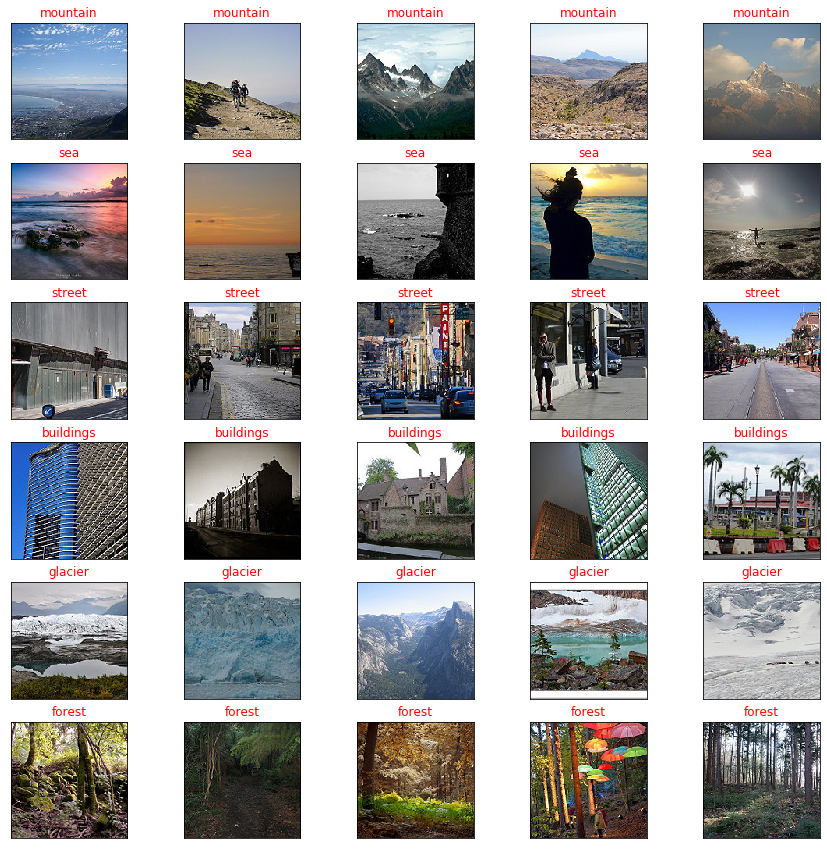

In [9]:
fig = plt.figure(figsize=(15, 15))

for i, img in enumerate(imgs):
  ax = fig.add_subplot(n_classes, n_imgs, i+1)
  ax.imshow(img)
  ax.set_title(labels[i], color='r')
  ax.set_xticks([])
  ax.set_yticks([])
    
plt.show()

In [10]:
train_tfms = transforms.Compose(
  [
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(**data_stats),    
  ]
)

pred_tfms = transforms.Compose(
  [
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(**data_stats)
  ]
)

In [11]:
ds = ImageFolder(data_path/'train', transform=train_tfms)

train_pct = 0.85
n_train = np.int(len(ds) * train_pct)
n_val = len(ds) - n_train

train_ds,val_ds = random_split(ds, [n_train, n_val])
train_ds,val_ds = train_ds.dataset,val_ds.dataset

In [12]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
train_itr = iter(train_dl)

val_dl = DataLoader(val_ds, batch_size=32)
val_itr = iter(val_dl)

test_ds = ImageFolder(data_path/'test', transform=pred_tfms)
test_dl = DataLoader(test_ds, batch_size=32)

In [13]:
imgs, labels = next(train_itr)

glacier


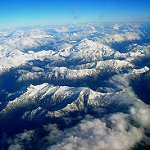

In [14]:
idx = np.random.randint(len(imgs))

print(train_ds.classes[labels[idx].item()])
img = for_disp(imgs[idx])
img

## Training